### Monte Carlo
First vs. Every Visit MC
* Tracking rewards received after visiting states
* Rewards received after first visit → First visit MC
* Rewards received after every visit → Every visit MC

### Blackjack Overview
* Player vs. Dealer; first to 21 wins, > 21 is a loss (bust)
* Ace worth 1 or 11, other face cards worth 10
* Ace that doesn’t cause a bust is called usable
* One dealer card is showing
* Inifinte deck with replacement → no counting
* State space is a 3 tuple:
    * Player sum (4-21), 
    * dealer showing card (ace – 10), 
    * boolean for a usable ace
* Reward +1 for winning, 0 for draw, -1 for loss
* Policy: draw new card (hit) if player total < 20, else stick

### Algorithm Overview
* Initialize the policy to be evaluated
* Initialize the value function arbitrarily
* Initialize list of returns for all states in the state space
* Repeat for large number of episodes:
    * Generate episode using policy
    * For each state s in the agent’s memory:
        * Calculate the return that followed first visit to s
        * Append return G to list of returns
        * Calculate the average of the returns for state s
* 500,000 games → print value of state (21, 2, True)
* Split into agent class and main function

In [1]:
import shutup
shutup.please()

import gym
import enum
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rich.table import Table
from rich.console import Console

### BlackJack setup
* Game and card setup
* Dealer turn logic
* Dealer hand value evaluation logic
* Player hand value evaluation logic

In [2]:
RANKS = {
    "two" : 2,
    "three" : 3,
    "four" : 4,
    "five" : 5,
    "six" : 6,
    "seven" : 7,
    "eight" : 8,
    "nine" : 9,
    "ten" : 10,
    "jack" : 10,
    "queen" : 10,
    "king" : 10,
    "ace" : (1, 11)
}
    
class Suit(enum.Enum):
    spades = "spades"
    clubs = "clubs"
    diamonds = "diamonds"
    hearts = "hearts"
    
class Card:
    def __init__(self, suit, rank, value):
        self.suit = suit
        self.rank = rank
        self.value = value
        
    def __str__(self):
        return self.rank + " of " + self.suit.value

class Deck:
    def __init__(self, num=1):
        self.cards = []
        for i in range(num):
            for suit in Suit:
                for rank, value in RANKS.items():
                    self.cards.append(Card(suit, rank, value))
                
    def shuffle(self):
        random.shuffle(self.cards)
        
    def deal(self):
        return self.cards.pop(0)
    
    def peek(self):
        if len(self.cards) > 0:
            return self.cards[0]
        
    def add_to_bottom(self, card):
        self.cards.append(card)
        
    def __str__(self):
        result = ""
        for card in self.cards:
            result += str(card) + "\n"
        return result
    
    def __len__(self):
        return len(self.cards)

In [3]:
class BlackJackAgent:
    def __init__(self):
        pass

    ### HAND EVALUATION LOGIC
    
    def dealer_hand_value_evaluation(self,hand):
        num_ace = 0
        use_one = 0
        for card in hand:
            if card.rank =="ace":
                num_ace +=1
                use_one += card.value[0] # Assume 1 for Ace
            else:
                use_one += card.value
                
        if num_ace > 0:
            # If has 11 instead of 1 for aces, dealer's hand is closer to the [17,21] range
            # Will follow Hard 17 rules ( dealer wont hi again is Ace yields a 17 )
            # Aces can be changed to 1's
            ace_counter = 0
            while ace_counter < num_ace:
                use_eleven = use_one + 10
                if use_eleven > 21:
                    return use_one
                elif use_eleven >= 17 and use_eleven <= 21:
                    return use_eleven
                else:
                    # The case where even using Ace as eleven is less than 17.
                    use_one = use_eleven
            
                ace_counter += 1
            return use_one
        else:
            return use_one
            
    def player_hand_value_evaluation(self,hand):
        num_ace = 0
        # use_one means that every ace that in the hand is counted as one.
        use_one = 0
        for card in hand:
            if card.rank == "ace":
                num_ace += 1
                use_one += card.value[0] # use 1 for Ace
            else:
                use_one += card.value

        if num_ace > 0:
            # Define player policy for Aces:
            # Make Aces 11 if they get you to the range [18,21]
            # Otherwise, use one.
            ace_counter = 0
            while ace_counter < num_ace:
                use_eleven = use_one + 10 

                if use_eleven > 21:
                    return use_one
                elif use_eleven >= 18 and use_eleven <= 21:
                    return use_eleven
                else:
                    # This allows for some Aces to be 11s, and others to be 1.
                    use_one = use_eleven

                ace_counter += 1

            return use_one
        else:
            return use_one
        
    ### PLAYER BET POLICY
    def discrete_policy(self,hand, deck):
        value = self.player_hand_value_evaluation(hand)

        # Implement Discrete Policy
        # If hand >= 18, stand. Otherwise, hit.
        while value < 18:
            # hit
            hand.append(deck.deal())
            value = self.player_hand_value_evaluation(hand)

        return value, hand, deck

    def stochastic_policy(self,hand, deck):
        value = self.player_hand_value_evaluation(hand)

        # Implement Stochastic Policy
        # If hand >= 18: 80% Stand, 20% Hit
        # Else: 80% Hit, 20% Stand

        stand = False
        while value < 18 and stand == False:
            percent = random.randint(1, 10)
            if percent <= 8:
                # hit
                hand.append(deck.deal())
                value = self.player_hand_value_evaluation(hand)
            else:
                # stand
                stand = True
    
        if stand:
            return value, hand, deck
    
        # player_value is now >= 18.
        if value < 21:
            percent = random.randint(1, 10)
            if percent > 8:
                # hit
                hand.append(deck.deal())
                value = self.player_hand_value_evaluation(hand)        

            # else: Do nothing, stand.
            # else: player_value is 21 or higher, so we must stand in both cases.

        return value, hand, deck
    
    
    ### TURN EVALUATION LOGIC
    
    def dealer_turn(self,dealer_hand,deck):
        # Calculate dealer hand's value.
        dealer_value = self.dealer_hand_value_evaluation(dealer_hand)
        
        # Define dealer policy (is fixed to official rules)

        # The dealer keeps hitting until their total is 17 or more
        while dealer_value < 17:
            # hit
            dealer_hand.append(deck.deal())
            dealer_value = self.dealer_hand_value_evaluation(dealer_hand)

        return dealer_value, dealer_hand, deck
    
    
    ### GAME LOGIC
    def play_game(self,player_policy, num_decks = 2, start_cash = 1000, num_rounds = 100):
        
        # Define game environment
        cash = start_cash
        rounds_played = 0
        
        # Our Blackjack deck will be made of 2 normal decks by default.
        deck = Deck(num_decks)
        deck.shuffle()
        
        # Bet 100 every round, loose 100 if looses, wins 100 if wins
        while rounds_played < num_rounds and cash > 0:
            my_hand = [deck.deal(), deck.deal()]
            dealer_hand = [deck.deal(), deck.deal()]
            
            # The current policy does not care about dealer's upcard.
            #dealer_upcard = dealer_hand[0]
            
            ## Begin player turn phase.
            my_value, my_hand, deck = player_policy(my_hand, deck)
            
            ## Player turn phase over.
            ## Begin automated phase of the Dealer's Play and check for winner    
            if my_value > 21: # above 21, player loses automatically.
                cash -= 100
            elif my_value == 21: # blackjack! Player wins automatically.
                cash += 100
            else:
                ## Begin dealer turn phase.

                dealer_value, dealer_hand, deck = self.dealer_turn(dealer_hand, deck)

                ## End of dealer turn phase
                ## Results
                if dealer_value > 21: # dealer above 21, player wins automatically
                    cash += 100
                elif dealer_value == 21: # dealer has blackjack, player loses automatically
                    cash -= 100
                else: # dealer and player have values less than 21.
                    if my_value > dealer_value: # player closer to 21, player wins.
                        cash += 100
                    elif my_value < dealer_value: # dealer closer to 21, dealer wins.
                        cash -= 100
                    # Nothing happens if a tie.
                    ## End of round formalities
        
            # Add all cards to the end of deck, and shuffle. 
            # (Shuffling not usually done in casino blackjack.)
            deck.cards += my_hand
            deck.cards += dealer_hand
            deck.shuffle()

            rounds_played += 1
            
        # Returns net gains/losses of playing
        return cash - start_cash

In [4]:
agent= BlackJackAgent()

### Discrete policy results

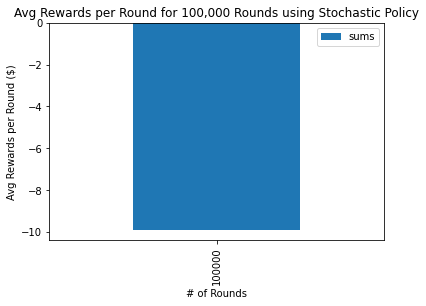

In [5]:
results = {}

num_rds = 1
num_games = 100000

net_avg = 0

for i in range(num_games):
    net_avg += agent.play_game(agent.discrete_policy, num_rounds = num_rds)
net_avg /= num_games

results[num_games] = net_avg

# Load rewards to a df
# x-axis will be # of games played. Not really an x-axis b/c there is just one value
# y-axis will the avg gains/losses for any given round using Stochastic Policy
df = pd.DataFrame(list(results.values()), columns = ["sums"], index = results.keys())

# sort by index align x/y axis properly
df.sort_index(inplace=True)

df.plot.bar()

plt.xlabel("# of Rounds")
plt.ylabel("Avg Rewards per Round ($)")
plt.title("Avg Rewards per Round for 100,000 Rounds using Stochastic Policy")

plt.show()
net_avg_discrete = net_avg

### Stochastic policy results

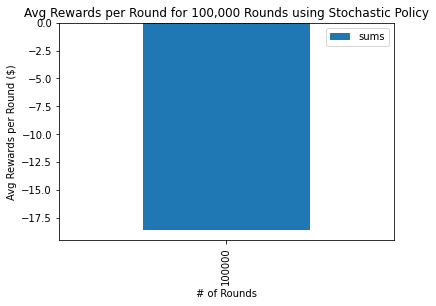

In [6]:
results = {}

num_rds = 1
num_games = 100000

net_avg = 0

for i in range(num_games):
    net_avg += agent.play_game(agent.stochastic_policy, num_rounds = num_rds)
net_avg /= num_games

results[num_games] = net_avg

# Load rewards to a df
# x-axis will be # of games played. Not really an x-axis b/c there is just one value
# y-axis will the avg gains/losses for any given round using Stochastic Policy
df = pd.DataFrame(list(results.values()), columns = ["sums"], index = results.keys())

# sort by index align x/y axis properly
df.sort_index(inplace=True)

df.plot.bar()

plt.xlabel("# of Rounds")
plt.ylabel("Avg Rewards per Round ($)")
plt.title("Avg Rewards per Round for 100,000 Rounds using Stochastic Policy")

plt.show()

net_avg_stochastic = net_avg

### Results overview

In [7]:
console = Console()
table = Table(show_header=True, header_style="bold magenta")
table.add_column("Policy", justify="right")
table.add_column("Average profit", justify="right")
table.add_row(
    "Discrete", str(net_avg_discrete)
)
table.add_row(
    "Stochastic", str(net_avg_stochastic)
)
console.print(table)

┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃     Policy ┃ Average profit ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│   Discrete │         -9.899 │
│ Stochastic │        -18.585 │
└────────────┴────────────────┘